## Portfolio Optimization

Given the historical series of a set of securities and of SP500, Brent price and 3M Treasury, you are asked to:
* find the Markowitz portfolio for a 0.32 expected annual return;
* draw efficient frontier of the risky portfolio and the CAL assuming an additional risk free asset (3M Treasury);
* find the Sharpe portfolio;
* comment the resulting plots.
As proxy for the risk-free rate use the average of 3M Treasury (rf column).

Using a two-factors model (SP500 and Brent), find:
* the best 10 assets to invest on given that there is strong evidence for a sudden decrease of Oil price. Motivate the choice (also looking at the sector of the assets, the info can be retrived using yfinance module).

The input is just an historical series file.

### Notes and Hints

Numerical results must be presented to the examining committee during a presentation in which the candidates will also explain the theoretical framework of the portfolio optimization models.

## Inputs

[Historical series](https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/proj8.csv)

In [24]:
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/proj8.csv", index_col ="Date")
print(data.head())

                   AAP       ABMD        AOS        APA        ATO       CBOE  \
Date                                                                            
2014-03-27  120.386787  25.770000  20.311985  70.738632  38.335091  53.106892   
2014-03-28  121.125298  25.700001  20.594727  71.548737  38.443562  52.420502   
2014-03-31  122.922981  26.040001  20.653065  71.488411  39.328094  53.219734   
2014-04-01  123.651749  26.200001  20.810135  72.186493  39.169537  52.956448   
2014-04-02  123.272804  26.000000  21.007603  72.591560  39.553406  51.950348   

                 Brent        COP        CVX        DVA  ...        NOV  \
Date                                                     ...              
2014-03-27  101.279999  55.201248  84.980484  68.389999  ...  61.768215   
2014-03-28  101.669998  56.045704  85.579918  68.449997  ...  63.100582   
2014-03-31  101.580002  56.045704  85.875999  68.849998  ...  63.263077   
2014-04-01   99.739998  56.013840  85.940994  69.339996  

In [3]:
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 52.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf

In [67]:
risky_data =data.copy()
risky_data.drop(['rf', 'Brent','SP500'], axis=1,inplace = True, errors='ignore')
#print(risky_data)

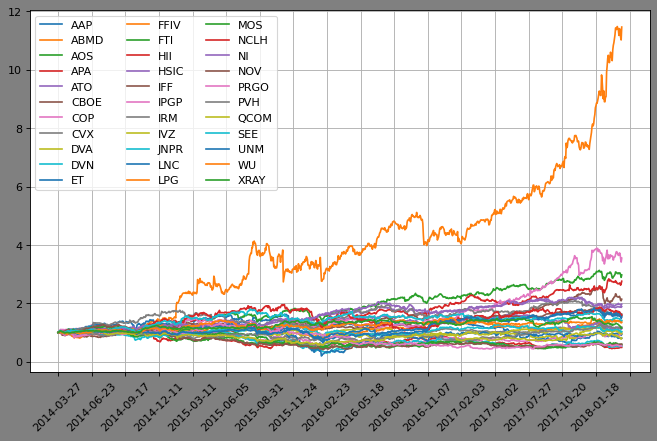

In [68]:


risky_d = risky_data/risky_data.iloc[0] #normalization operation

fig = plt.figure(figsize=(10,6), dpi=80, facecolor ='grey')  #my canvas
for i in risky_d.columns:
  plt.plot(risky_d[i], label=i)
plt.legend(ncol=3)  
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=45)
plt.grid(True)                                                            

plt.show()

In [ ]:
riskydaily_returns = risky_data.pct_change()
risky_ret = riskydaily_returns.mean()*252
print(risky_ret)

AAP     0.032100
ABMD    0.701586
AOS     0.297326
APA    -0.103439
ATO     0.183844
CBOE    0.209726
COP     0.041632
CVX     0.060103
DVA     0.012973
DVN    -0.066576
ET      0.118743
FFIV    0.115763
FTI    -0.080091
HII     0.283627
HSIC    0.050928
IFF     0.133327
IPGP    0.365671
IRM     0.153760
IVZ     0.035622
JNPR    0.047093
LNC     0.154745
LPG    -0.116462
MOS    -0.088737
NCLH    0.169657
NI      0.177186
NOV    -0.069007
PRGO   -0.094399
PVH     0.084553
QCOM   -0.013666
SEE     0.114886
UNM     0.131544
WU      0.096664
XRAY    0.054661
dtype: float64


In [ ]:
covariance2 = riskydaily_returns.cov()*252
#print(covariance2)

MARKOWITZ PORTFOLIO

In [ ]:
import numpy as np
from  scipy.optimize import minimize

#i've just dropped out the risk free rate, leaving in my ptf the 2 indices : s&p, brent

def sum_weights(w):          # 1th constr
    return np.sum(w) - 1

def min_risk(w, cov):        #function to minimize risk (our objective)
    return w.T.dot(covariance2.dot(w))

def target_return (w, ret, target_return):    #2th constr.
    return(risky_ret.dot(w)- target_return)


num_assets = 33
constraints = [{'type': 'eq', 'fun': sum_weights}, 
               {'type': 'eq', 'fun': target_return, 'args':(risky_ret,0.32)}]
bounds = tuple((0,1) for  _ in range (num_assets))
weights = [1./num_assets for _ in range (num_assets)]

optimiz = minimize(min_risk, weights, args=(covariance2), bounds=bounds,constraints = constraints)

print(optimiz)
print("Expected Ptf Return: {:.3f}".format(risky_ret.dot(optimiz.x)))

     fun: 0.02123051609433754
     jac: array([0.02456971, 0.08976802, 0.03979901, 0.02760451, 0.02550426,
       0.02863476, 0.02403303, 0.02210507, 0.02069929, 0.0304063 ,
       0.049764  , 0.03101653, 0.02562483, 0.03808623, 0.02429358,
       0.02525003, 0.0483786 , 0.02720304, 0.03981351, 0.03050706,
       0.03644888, 0.01910315, 0.02600487, 0.03151603, 0.02472927,
       0.01903793, 0.02546463, 0.02571882, 0.02560198, 0.03166889,
       0.02655828, 0.02934726, 0.02413771])
 message: 'Optimization terminated successfully'
    nfev: 612
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([7.25464501e-18, 1.77495566e-01, 1.27239155e-01, 0.00000000e+00,
       2.57062219e-01, 2.07232445e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.58675454e-17, 6.78728123e-18, 0.00000000e+00,
       0.00000000e+00, 9.65522514e-02, 0.00000000e+00, 0.00000000e+00,
       8.33851193e-02, 1.45868514e-17, 3.10607604e-18, 0.00000000e+00,
       0.00000000e+00, 0.00000000

In [ ]:
weights =[7.25464501e-18, 1.77495566e-01, 1.27239155e-01, 0.00000000e+00,
       2.57062219e-01, 2.07232445e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.58675454e-17, 6.78728123e-18, 0.00000000e+00,
       0.00000000e+00, 9.65522514e-02, 0.00000000e+00, 0.00000000e+00,
       8.33851193e-02, 1.45868514e-17, 3.10607604e-18, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.77419650e-18, 0.00000000e+00,
       5.10332440e-02, 0.00000000e+00, 1.17813835e-18, 7.57142198e-18,
       4.43827033e-18, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00]
w = np.array(weights)
var = w.T.dot(covariance2.dot(w))
stdev= np.sqrt(var)
print(stdev)

0.14570695285062596


In [ ]:
exp_risky = w.T.dot(risky_ret)
print(exp_risky)

0.32000000013847385


EFFICIENT FRONTIER

In [ ]:
result = []
for target in np.arange(0.20,0.50,0.005):
  constraints = ({'type':'eq', 'fun':sum_weights},
                 {'type': 'eq', 'fun':target_return, 'args':(risky_ret, target)})
  weights = [1./num_assets for _ in range(num_assets)]
  opts = minimize(min_risk,weights,args=(covariance2), bounds=bounds, constraints=constraints)

  result.append((np.sqrt(opts.x.T.dot(covariance2.dot(opts.x))), 
                 risky_ret.dot(opts.x)))

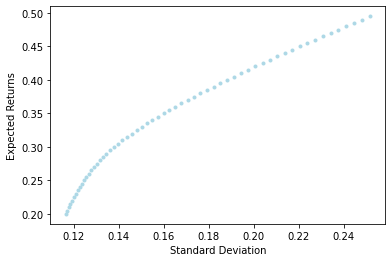

In [ ]:
import matplotlib.pyplot as plt

std_devs = [x[0] for x in result] 
exp_returns = [x[1] for x in result]

plt.scatter(std_devs, exp_returns, marker='.', color='lightblue')
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Returns')
plt.show()

In [ ]:
data_rf = data.copy()
rf= data_rf[[data_rf.columns[-1]]]
print(rf)

                 rf
Date               
2014-03-27  0.00033
2014-03-28  0.00033
2014-03-31  0.00028
2014-04-01  0.00030
2014-04-02  0.00018
...             ...
2018-03-20  0.01758
2018-03-21  0.01710
2018-03-22  0.01683
2018-03-23  0.01688
2018-03-26  0.01705

[1007 rows x 1 columns]


In [ ]:
rf_ret = rf.mean()
print(rf_ret)


rf    0.004071
dtype: float64


Portfolio with risk-free asset

rf    0.288407
dtype: float64
0.13113625756556338


/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


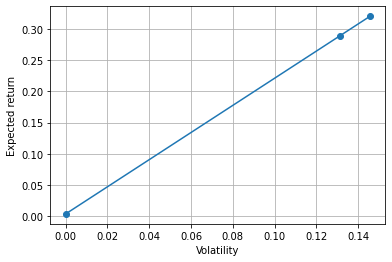

In [ ]:
#num_assets = 34

exp_ptf1 = (exp_risky*0.9) + (rf_ret*0.1)
print(exp_ptf1)
vol_ptf = (stdev*0.9)
print(vol_ptf)
#returns_ptf= np.append(risky_ret,rf_ret)
#cov_ptf = np.column_stack((covariance2, np.zeros((33))))
#cov_ptf = np.row_stack((cov_rf, np.zeros(34)))
#print(cov_rf)
#exp_ptf = (0.32*0.1)+(0.097046*0.9)
#print(exp_ptf)
st_dev_ptf = 0.10*stdev
#print(var_ptf)


x = [0,vol_ptf, stdev]
y = [rf_ret,exp_ptf1,exp_risky]
plt.plot(x, y, marker='o')
plt.xlabel("Volatility")
plt.ylabel("Expected return")
plt.grid(True)
plt.savefig("")


CAL

In [ ]:
num_assets = 34

cov_rf = np.column_stack((covariance2.values,np.zeros(33)))
cov_rf=np.row_stack((cov_rf, np.zeros(34)))

def min_risk(w,cov,n_riskfree=0):
  n_risk_free = len(rf_ret)
  if n_riskfree ==0:
    return w.T.dot(cov_rf.dot(w))
  else:
    return w[:-n_riskfree].T.dot(covariance2.dot(w[:-n_riskfree]))

def target_return(w, returns, target_return, returns_rf):
  n_risk_free = len(rf_ret)
  if n_risk_free == 0: 
    portfolio_return = risky_ret.dot(w)
    return (portfolio_return - target_return)
  else: 
    portfolio_return = risky_ret.dot(w[:-n_risk_free]) + np.array(rf_ret).dot(w[-n_risk_free:]) 
    return (portfolio_return - target_return)

rf_asset_return = [rf_ret]
results_rf = []
bounds = [(0, 1) for asset in range(num_assets)]

for target in np.arange(0.10, 0.45, 0.01):
    constraints = ({'type': 'eq', 'fun': target_return, "args":(risky_ret, target, rf_ret)},
                   {'type': 'eq', 'fun': sum_weights})
    weights = [1./num_assets for _ in range(num_assets)]
    optz = minimize(min_risk, weights, args=(cov_rf, 1),
                    bounds=bounds, constraints=constraints)
    
    results_rf.append((np.sqrt(min_risk(optz.x,cov_rf, 1)), target))

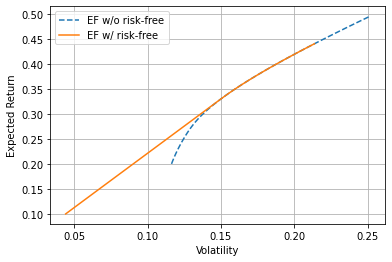

In [ ]:
results_rf = np.array(results_rf)
result = np.array(result)

plt.plot(result[:, 0], result[:, 1], linestyle="--", label='EF w/o risk-free')
plt.plot(results_rf[:, 0], results_rf[:, 1], label='EF w/ risk-free')
plt.xlabel("Volatility")
plt.ylabel("Expected Return")
plt.grid(True)
plt.legend()

SHARPE RATIO

In [ ]:
from scipy import optimize
num_assets = len(risky_ret)
rfasset_ret = rf_ret

def sharpe_ratio(w, returns, rfasset_ret, cov): 
    ptf_ret = risky_ret.dot(w)
    ptf_vol = np.sqrt(w.T.dot(covariance2.dot(w)))
    ratio = -(ptf_ret - rfasset_ret) / ptf_vol
    return ratio

constraints = ({'type': 'eq', 'fun': sum_weights})
bounds = tuple((0, 1) for asset in range(num_assets))
weights = [1./num_assets for _ in range(num_assets)]
optim = minimize(sharpe_ratio, weights, args=(risky_ret, rfasset_ret, covariance2),
                bounds=bounds, constraints=constraints)
print (optim)

     fun: rf   -2.170959
dtype: float64
     jac: array([ 0.98509026, -0.0272285 , -0.0265747 ,  2.03527033, -0.02683866,
       -0.02712974,  0.88637361,  0.66760734,  0.92691922,  1.92629179,
        1.65648463,  0.77277941,  1.79152337, -0.02710456,  0.84802052,
        0.33679411, -0.02779543,  0.28532141,  1.72128007,  1.19631907,
        0.76906568,  1.71423593,  1.86853758,  0.42300946, -0.02683643,
        1.38655755,  1.87713367,  0.70220861,  1.35098019,  0.78108829,
        0.42673856,  0.80245849,  0.82200623])
 message: 'Optimization terminated successfully'
    nfev: 552
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([0.00000000e+00, 1.96798870e-01, 1.29748262e-01, 0.00000000e+00,
       2.49568494e-01, 1.99325420e-01, 3.83292182e-15, 0.00000000e+00,
       1.71679137e-15, 1.27319916e-15, 2.53791341e-16, 0.00000000e+00,
       2.53773081e-16, 9.60797557e-02, 0.00000000e+00, 0.00000000e+00,
       8.73422108e-02, 0.00000000e+00, 0.00000000e+00, 2.0234

In [ ]:
print ("Sharpe ratio: ", -optim.fun)

Sharpe ratio:  rf    2.170959
dtype: float64


In [ ]:

ptf_ret = risky_ret.dot(optim.x)
ptf_vol = np.sqrt(optim.x.T.dot(covariance2.dot(optim.x)))
print(ptf_ret)
print(ptf_vol)

0.3308124821203044
0.15050566021914216


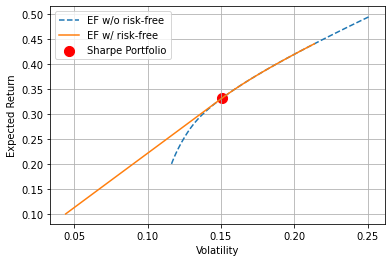

In [ ]:
plt.plot(result[:, 0], result[:, 1], linestyle="--", label='EF w/o risk-free')
plt.plot(results_rf[:, 0], results_rf[:, 1], label='EF w/ risk-free')
plt.scatter([ptf_vol], [ptf_ret], marker='o', s=102, label = "Sharpe Portfolio", color='red', zorder=1)
plt.xlabel("Volatility")
plt.ylabel("Expected Return")
plt.grid(True)
plt.legend()
plt.savefig("sharpe_ratio.png")

* The first objective was to compute an optimized portfolio according to Markowitz Portfolio Theory.
The M. Portfolio (efficient ptf) is the one with the lowest risk given a certain level of return (or the highest return given a certain level of volatility). 
I imposed a target return of 0.32 obtaining the lowest possible standard-deviation . 
In the first optimization problem there were only risky assets which composed the efficient frontier (a curve representing all efficient portfolios).
* In the second optimization problem I've insered also a risk free asset. The efficient frontier obtained is now a straight increasing line (the CAL), starting from the portfolio made of the risk_free asset only. 
The slope of this line measures the trade off between risk and return (higher slope corresponds to higher returns given higher risk taken by investors). 
The CAL is tangent to the efficient frontier including risky assets.
* The susequent step is the computation of the Sharpe portfolio.
The objective, as investor, is to find the portfolio which provide the highest possible return compared to the risk-free investement. The excess of return compared to the additional risk taken is measured by the Sharpe ratio. It is computed by  
$\frac{(R_p-r_f)}{\sigma_p}$, which means (the difference between the return of portfolio and the risk free rate, divided by the standard deviation of the portfolio. 
The Sharpe Ratio turned out to be 2.17.

**2-FACTORS MODEL REGRESSIONS ***

In [2]:
sp = data['SP500'].pct_change()
s = pd.Series(sp)

pd.options.display.max_rows = None
#print(s)

print(sp.mean())

0.00039285977610472916


In [5]:
dataregression= data.copy()
dataregression.drop(['rf'], axis=1, inplace=True,errors='ignore')
#print(dataregression)
returns = dataregression.pct_change()
returns= returns.drop(returns.index[0])

#log_returns = np.log(returns+1)
#print(returns)

In [6]:
data_rf = data.copy()
rf= data_rf[[data_rf.columns[-1]]]
rf1 = ((1+rf)**(1/252)-1)
rf2= rf1.drop(rf1.index[0])
#logrf = np.log(rf2+1)
#print(logrf)
#print(rf2)

In [7]:
#excess returns
array1 = returns.values
array2 = rf2.values

result = array1 - array2

excess_returns = pd.DataFrame(result, columns=returns.columns)
#print(excess_returns)

In [8]:
from sklearn.impute import SimpleImputer

# Replace NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')
excess_ret = imputer.fit_transform(excess_returns)
#print(excess_ret)
excess_returns_2= pd.DataFrame(excess_ret, columns=excess_returns.columns)
#print(excess_returns_2)

In [9]:
#multilinear regressions
res = {}
tickers = list(excess_returns_2.columns)
tickers.remove('SP500')
tickers.remove('Brent')
for t in tickers:
  y = excess_returns_2[t]
  X = excess_returns_2[['SP500','Brent']]
  X = sm.add_constant(X)
  model = sm.OLS(y, X).fit()
  print ("{:.4f}".format((1+model.params[0])**(252)-1))
  print(model.summary())
  res[t] = {'params':model.params, 'pvals':model.pvalues}

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versi

-0.0606
                            OLS Regression Results                            
Dep. Variable:                    AAP   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     72.97
Date:                Wed, 01 Feb 2023   Prob (F-statistic):           2.60e-30
Time:                        21:14:35   Log-Likelihood:                 2591.2
No. Observations:                1006   AIC:                            -5176.
Df Residuals:                    1003   BIC:                            -5162.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.426 

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versi

0.0575
                            OLS Regression Results                            
Dep. Variable:                    IRM   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     117.7
Date:                Wed, 01 Feb 2023   Prob (F-statistic):           1.19e-46
Time:                        21:14:35   Log-Likelihood:                 2853.7
No. Observations:                1006   AIC:                            -5701.
Df Residuals:                    1003   BIC:                            -5687.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.495  

In [10]:
print(res)

{'AAP': {'params': const   -0.000248
SP500    0.914485
Brent   -0.051660
dtype: float64, 'pvals': const    6.699955e-01
SP500    5.526057e-31
Brent    4.521807e-02
dtype: float64}, 'ABMD': {'params': const    0.002290
SP500    1.171819
Brent   -0.083396
dtype: float64, 'pvals': const    4.234760e-03
SP500    1.865430e-27
Brent    1.848993e-02
dtype: float64}, 'AOS': {'params': const    0.000737
SP500    1.188316
Brent   -0.005049
dtype: float64, 'pvals': const     2.333861e-02
SP500    1.924495e-127
Brent     7.251497e-01
dtype: float64}, 'APA': {'params': const   -0.000614
SP500    1.029435
Brent    0.497211
dtype: float64, 'pvals': const    2.838395e-01
SP500    2.594061e-39
Brent    8.573095e-73
dtype: float64}, 'ATO': {'params': const    0.000482
SP500    0.565325
Brent   -0.042236
dtype: float64, 'pvals': const    1.129091e-01
SP500    9.710834e-42
Brent    1.737562e-03
dtype: float64}, 'CBOE': {'params': const    0.000606
SP500    0.544892
Brent   -0.071147
dtype: float64, 'pvals

Looking at the results of the multilinear regressions above, computed for 33 stocks toward SP500 and Brent we're able to chose a set of the best 10 assets to invest in , also considering that we're expecting a strong decrease of the oil price. I started my analysis by observing the sectors of each asset and isolating those more sensible to the oil price variations, e.g. = energy, industrial and basic material. I've also computed the correlations with respect to Brent data and chosed the ones the responded better to past decreases in its price. After that,I've looked at the regressions: firstly I discarded the ones with a very poor R^2 (for example values like 0.112,0.190, generally those below 0.2); secondly looked the estimated coefficients (betas) for s&p and Brent, discarding those assets with a significant and positive coefficient with respect to Brent, preferrying the ones with negative and/or not significant with respect to Brent (rembembering that the coefficient beta represent the sensitivity with respect to the index). Lastily, I pointed out the** postive alphas** (which refer to the performances of the assets not considering their dependence on indices), in some cases I also chosed assets with -not overly- negative aplhas coefficients , but with other convincing characteristics (e.g. negative or not significant beta of Brent and also the correlations with sp data in the previous periods). Finally my choice is : AOS,HII,IFF,IPGP, FFIV,NCLH,NI,HSCI,SEE,WU. The majority of the chosen assets present a postive alpha and a negative or not significant beta for Brent. The two cases of poor (not overly negative) alphas is supported by the strenghten of other parameters. In the case of IFF, we can observe a very very weak positive correlation with Brent (0.034), with poor evidences of significance; the asset comes from Basic materials sectors, but its correlations show its strong resilience with respect to the poor performance of Oil price, reason for which I decide to prefer it to ohter less convincing assets. The other stocks, with the exception of AOS, IFF and HII, come from sectors not sensible to Oil Price.

In [11]:
tickers = ['AAP','ABMD','AOS','APA','ATO','CBOE','COP','CVX','DVA','DVN','ET','FFIV','FTI','HII','HSIC','IFF','IPGP','IRM','IVZ','JNPR','LNC','LPG','MOS','NCLH','NI','NOV','PRGO','PVH','QCOM','SEE','UNM','WU','XRAY']

proxy = yf.Tickers(tickers)
df = proxy.history(start='2014-03-27', end='2018-03-26')
df1 =df['Close']
df2=df1.pct_change()
df3 = df2.drop(df2.index[0])

#print(df3)

[*********************100%***********************]  33 of 33 completed


In [12]:

for stock in tickers:
    
    ticker = yf.Ticker(stock)
    
    info = ticker.info
    
    sector = info['sector']
 
    print(f"Stock: {stock}, Sector: {sector}")

Stock: AAP, Sector: Consumer Cyclical
Stock: ABMD, Sector: Healthcare
Stock: AOS, Sector: Industrials
Stock: APA, Sector: Energy
Stock: ATO, Sector: Utilities
Stock: CBOE, Sector: Financial Services
Stock: COP, Sector: Energy
Stock: CVX, Sector: Energy
Stock: DVA, Sector: Healthcare
Stock: DVN, Sector: Energy
Stock: ET, Sector: Energy
Stock: FFIV, Sector: Technology
Stock: FTI, Sector: Energy
Stock: HII, Sector: Industrials
Stock: HSIC, Sector: Healthcare
Stock: IFF, Sector: Basic Materials
Stock: IPGP, Sector: Technology
Stock: IRM, Sector: Real Estate
Stock: IVZ, Sector: Financial Services
Stock: JNPR, Sector: Technology
Stock: LNC, Sector: Financial Services
Stock: LPG, Sector: Energy
Stock: MOS, Sector: Basic Materials
Stock: NCLH, Sector: Consumer Cyclical
Stock: NI, Sector: Utilities
Stock: NOV, Sector: Energy
Stock: PRGO, Sector: Healthcare
Stock: PVH, Sector: Consumer Cyclical
Stock: QCOM, Sector: Technology
Stock: SEE, Sector: Consumer Cyclical
Stock: UNM, Sector: Financial Se

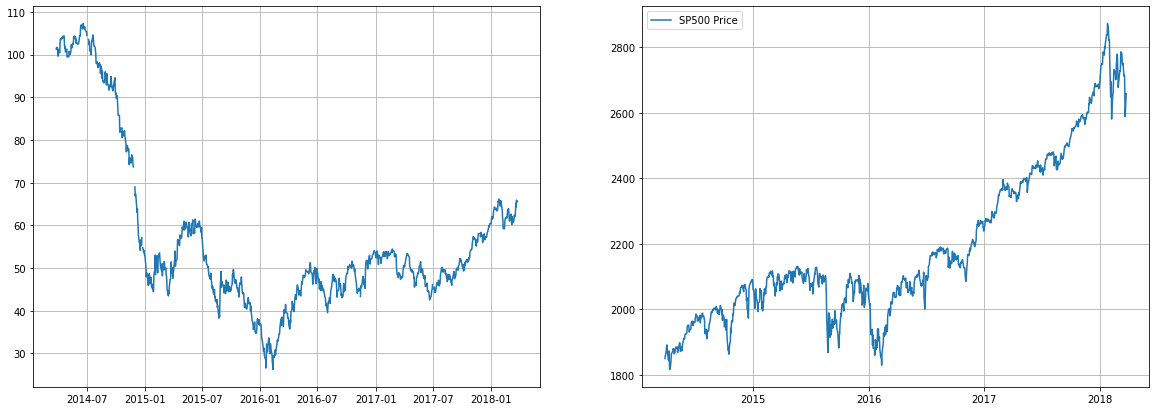

In [65]:
from matplotlib.dates import YearLocator, DateFormatter
fig = plt.figure(figsize=(20,7))

sub1 = plt.subplot(1,2,1)
sub1.plot(pd.to_datetime(data.index), data["Brent"], label='Brent Price')
sub1.grid(True)



sub2 = plt.subplot(1,2,2)
sub2.plot(pd.to_datetime(data.index), data["SP500"], label='SP500 Price')
sub2.grid(True)


plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(YearLocator())
plt.legend(loc = 'upper left')
plt.show()

correlations between Brent and assets of sectors more sensitive toward Oil Price, in the ranges of time of: 1) fall of the price; 2)moderate increase of the price

In [13]:
#fall of the price 
tickers_sectors = ['CVX', 'DVN', 'ET', 'FTI','NOV','LPG','COP','APA','IFF','MOS','AOS','HII']
data = yf.download(tickers_sectors, start="2014-07-31", end="2016-02-11")


brent = yf.download('BZ=F', start="2014-07-31", end="2016-02-11")
correlation = data['Close'].corrwith(brent['Close'])
print(correlation)

[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  1 of 1 completed
AOS   -0.763043
APA    0.944886
COP    0.897579
CVX    0.864528
DVN    0.815511
ET     0.579181
FTI    0.961632
HII   -0.577466
IFF   -0.681801
LPG    0.872467
MOS    0.604301
NOV    0.935114
dtype: float64


In [14]:
#rise of the oil price
data = yf.download(tickers_sectors, start="2016-02-12", end="2018-03-26")


brent = yf.download('BZ=F', start="2016-02-12", end="2018-03-26")
correlation = data['Close'].corrwith(brent['Close'])
print(correlation)

[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  1 of 1 completed
AOS    0.840730
APA   -0.316784
COP    0.932122
CVX    0.891390
DVN    0.416960
ET     0.567856
FTI    0.383128
HII    0.881637
IFF    0.695879
LPG   -0.137766
MOS   -0.069670
NOV    0.519257
dtype: float64


In [15]:
#correlations with sp
data_2 = yf.download(tickers, start="2014-07-31", end="2018-03-26")
sp = yf.download('^GSPC', start="2014-07-31", end="2018-03-26")
correlation_2 = data_2['Close'].corrwith(sp['Close'])
a = pd.Series(correlation_2)
pd.options.display.max_rows = None
print(a)
#print(correlation)

[*********************100%***********************]  33 of 33 completed
[*********************100%***********************]  1 of 1 completed
AAP    -0.674346
ABMD    0.891967
AOS     0.922887
APA    -0.439817
ATO     0.779465
CBOE    0.948428
COP    -0.170465
CVX     0.533612
DVA    -0.399321
DVN    -0.336869
ET     -0.258935
FFIV    0.574241
FTI    -0.377981
HII     0.939582
HSIC    0.283980
IFF     0.848406
IPGP    0.945201
IRM     0.387322
IVZ     0.005397
JNPR    0.480856
LNC     0.867121
LPG    -0.557716
MOS    -0.540569
NCLH    0.403801
NI      0.694372
NOV    -0.392725
PRGO   -0.669357
PVH     0.608100
QCOM   -0.083426
SEE     0.163885
UNM     0.947620
WU      0.393244
XRAY    0.540153
dtype: float64


I've also implemented a **PCA** analysis in order to look and compare the results , given the different assumptions under the two approaches.


In [16]:
equities = df3.iloc[:,:-1]
cov = equities.cov()*252
eigVals, eigVecs = np.linalg.eig(cov)


In [17]:
norm_eigVecs = abs(eigVecs.T[0])/sum(abs(eigVecs.T[0]))

pc_daily_ret = equities.dot(norm_eigVecs)
pc_cum_ret = pc_daily_ret.cumsum()

In [18]:
best_idx = np.argsort(eigVecs.T[0])[-10:]
eq_best = equities.iloc[:,best_idx]
best_eigv = norm_eigVecs[best_idx]
best_ret= eq_best.dot(best_eigv).cumsum()
print("Best:", df.columns[best_idx])

Best: MultiIndex([('Close', 'IVZ'),
            ('Close', 'MOS'),
            ('Close', 'LNC'),
            ('Close', 'NOV'),
            ('Close', 'FTI'),
            ('Close', 'COP'),
            ('Close', 'LPG'),
            ('Close', 'APA'),
            ('Close', 'DVN'),
            ('Close',  'ET')],
           )
